# 深度学习平台课程实验教程

## 神经网络基础

**目标**
通过本次实验，你将掌握以下内容：

1. 感知机、多层感知机(MLP)、激活函数的使用。
2. 实现一个多层感知机模型，用于MNIST数据集的数字分类。
3. 多种常用激活函数和正则化方法。

------
### **1. 感知机**
感知机是人工神经网络中最简单的一种形式，它由输入层、输出层组成，不包含隐藏层。  
然而，感知机只能解决线性可分的问题，无法产生非线性分割面，因此无法解决非线性问题。

### **2. 多层感知机的从零实现**
多层感知机是一种前馈人工神经网络模型，除了输入层和输出层之外还包含一个或多个隐藏层。每一层都完全连接到下一层。  
MLP可以学习非线性的函数映射，适用于更复杂的数据模式识别任务，如图像分类。  
首先导入所需模块：

In [36]:
import torch
import numpy as np
from torchvision import datasets, transforms

MNIST数据集是由0〜9手写数字图片和数字标签所组成的，由60000个训练样本和10000个测试样本组成，  
其中每个样本都是一张28 * 28像素的灰度手写数字图，适合初学者进行图像分类任务。  
加载与预处理MNIST数据集

In [37]:
# 参数trainset应是一个实现了__len__和__getitem__方法的对象，代表整个MNIST训练数据集。
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

创建数据加载器

In [38]:

# batch_size=64表示每个批次包含64个样本。可以根据硬件（如内存/GPU显存）调整这个值。
# shuffle=True表示在每个epoch开始时都将训练数据集打乱顺序。
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
#对于测试集我们通常不需要打乱顺序
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

思考：如果不打乱训练集，会对训练结果产生什么影响？

定义模型所需参数

In [39]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

定义激活函数，这里采用ReLU

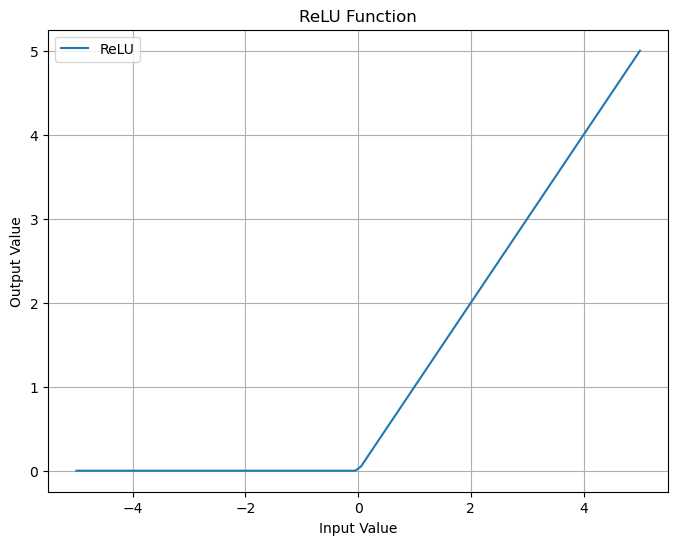

In [40]:
import matplotlib.pyplot as plt

# 定义ReLU函数
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

# 生成一系列X, Y值作为输入
x_values = torch.linspace(-5, 5, 100)
y_values = relu(x_values)

# 绘制图像
plt.figure(figsize=(8, 6)) # 设置图表大小
plt.plot(x_values.numpy(), y_values.numpy(), label='ReLU') # 绘制ReLU曲线
plt.title('ReLU Function') # 图表标题
plt.xlabel('Input Value') # x轴标签
plt.ylabel('Output Value') # y轴标签
plt.legend() # 显示图例
plt.grid(True) # 显示网格
plt.show() # 显示图表

定义模型结构

In [41]:
def net(X): 
    X = X.view((-1, num_inputs)) # view函数将每张原始图像改成长度为num_inputs的向量
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

定义损失函数，这里采用交叉熵损失

In [42]:
loss = torch.nn.CrossEntropyLoss()

定义优化器，这里依然采用最简单的随机梯度下降方法

In [43]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            # 对每个参数按照其梯度以及学习率进行更新。
            param -= lr * param.grad / batch_size
            # 我们希望根据新的数据重新计算梯度，而不是累加之前的梯度。
            param.grad.zero_()

定义准确率函数

In [44]:
def evaluate_accuracy(dataloader, net):
    acc_sum, n = 0.0, 0
    for X, y in dataloader:
        y_hat = net(X)
        pred = y_hat.argmax(dim=1)
        acc_sum += (pred == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

训练模型

In [45]:
num_epochs = 5 
lr = 0.1

def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)  #梯度下降
            else:
                optimizer.step()  #更新参数

            
            # 计算准确率 TODO
            # 计算准确率 TODO
            pred = y_hat.argmax(dim=1)
            train_acc_sum += (pred == y).float().sum().item()
            train_l_sum += l.item()  # 损失值累加
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train(net, trainloader, testloader, loss, num_epochs, batch_size=64, params=params, lr=lr)

epoch 1, loss 0.0357, train acc 0.449, test acc 0.591
epoch 2, loss 0.0344, train acc 0.599, test acc 0.619
epoch 3, loss 0.0313, train acc 0.643, test acc 0.683
epoch 4, loss 0.0258, train acc 0.699, test acc 0.728
epoch 5, loss 0.0201, train acc 0.738, test acc 0.772


### **3. 多层感知机的简单实现**
首先加载MNIST数据集

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms


trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

定义MLP模型

In [47]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.f1 = nn.Linear(num_inputs, num_hiddens) # 输入层 -> 隐藏层
        self.f2 = nn.Linear(num_hiddens, num_outputs) # 隐藏层 -> 输出层
        
    def forward(self, x):
        x = x.view(-1, num_inputs) # 将每张原始图像改成长度为num_inputs的向量
        x = F.relu(self.f1(x)) # 使用PyTorch中的ReLU激活函数
        x = self.f2(x)
        return x

实例化模型、损失函数和优化器

In [48]:
net = MLP(num_inputs, num_outputs, num_hiddens)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

定义准确率函数

In [49]:
def evaluate_accuracy(dataloader, net):
    acc_sum, n = 0.0, 0
    for X, y in dataloader:
        y_hat = net(X)
        pred = y_hat.argmax(dim=1)
        acc_sum += (pred == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

训练模型

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.f1 = nn.Linear(num_inputs, num_hiddens) # 输入层 -> 隐藏层
        self.f2 = nn.Linear(num_hiddens, num_outputs) # 隐藏层 -> 输出层
        
    def forward(self, x):
        x = x.view(-1, num_inputs) # 将每张原始图像改成长度为num_inputs的向量
        x = F.relu(self.f1(x)) # 使用PyTorch中的ReLU激活函数
        x = self.f2(x)
        return x


def train(net, train_iter, test_iter, loss, num_epochs, optimizer):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)  
            
            # 清除梯度
            optimizer.zero_grad()
            
            # 反向传播
            l.backward()
            
            # 更新参数
            optimizer.step()
            
            # 计算准确率
            pred = y_hat.argmax(dim=1)
            train_acc_sum += (pred == y).float().sum().item()
            train_l_sum += l.item()  # 累加损失值
            n += y.shape[0]
        
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


num_epochs = 5
num_inputs, num_outputs, num_hiddens = 784, 10, 256
net = MLP(num_inputs, num_outputs, num_hiddens)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

train(net, trainloader, testloader, loss, num_epochs, optimizer)

epoch 1, loss 0.0068, train acc 0.885, test acc 0.924
epoch 2, loss 0.0034, train acc 0.937, test acc 0.947
epoch 3, loss 0.0025, train acc 0.953, test acc 0.957
epoch 4, loss 0.0020, train acc 0.964, test acc 0.965
epoch 5, loss 0.0017, train acc 0.970, test acc 0.969
